Byte-Pair Encoding
==================
'Neural Machine Translation of Rare Words with Subword Units' by Rico Sennrich, Barry Haddow, Alexandria Burch 논문 참고

BPE(Byte-Pair Encoding)은 ['Neural Machine Translation of Rare Words with Subword Units'](https://arxiv.org/pdf/1508.07909.pdf) 논문에서 소개된 방식을 따른다. BPE는 training data를 통해서 BPE set을 구하는 과정과, 구해진 BPE set을 이용해 word embedding을 통해 학습시키려고 하는 text 데이터를 변형하는 두 과정으로 나뉜다.

### BPE 학습
BPE를 간단하게 설명하자면 캐릭터 단위로 잘게 쪼개는 전처리를 마친 단어 데이터가 주어져 있을 때, 인접 캐릭터의 Bigram pair 를 만들어, 가장 빈번하게 발생하는 pair(most frequent)를 저장한다. 그 후, most frequent 쌍을 한개의 캐릭터(혹은 토큰)으로 바꾸어 전체 딕셔너리의 Bigram pair를 다시 만든다. 그 후, most frequent pair를 찾고 저장, 그 후 토큰화하는 과정을 원하는 BPE set의 크기만큼 반복한다. 이 과정을 거치면 training data에 존재하는 텍스트에서 가장 빈번하게 반복되는 n 개의 pair만큼의 BPE set을 구할 수 있다.<br>

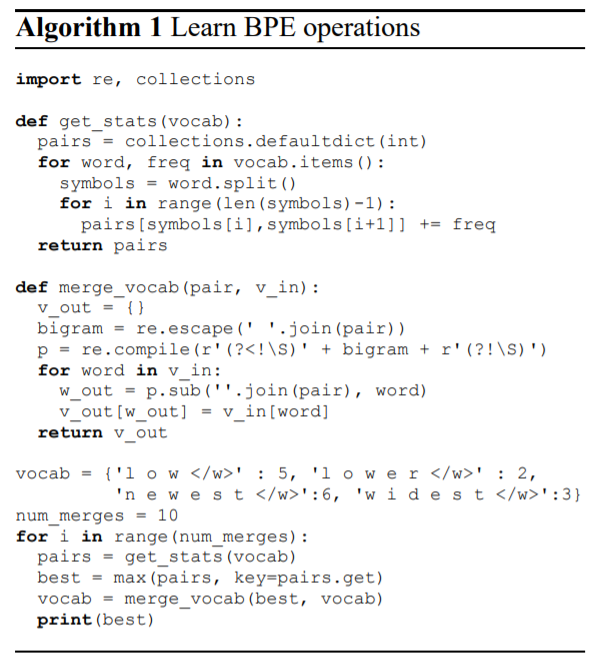<br>
BPE 알고리즘을 인덱싱 등등을 고려하지 않고 매우 간단하게 표현한 논문 속의 코드이다. 논문의 예시에서는<br>
vocab dictionary 속에는 l o w (eow), l o w e r (eow), n e w e s t (eos), w i d e s t (eow) 등이 포함되어 있다. BPE를 수행할 경우 l o -> lo, lo w -> low, r (eow )-> r(eow), e r(eow) -> er(eow) 등으로 점점 합쳐지는 pair들을 발견할 수 있다.

In [7]:
import json
import ftfy
import spacy
import itertools
import collections
import re
import copy
import codecs
import sys

데이터 전처리와 토큰화에는 ftfy, spacy 패키지를 사용함

In [8]:
def text_standardize(text):
    # 여러 출처의 텍스트의 서로 다른 포맷을 규격화
    """
    fixes some issues the spacy tokenizer had on books corpus
    also does some whitespace standardization
    """
    text = text.replace('—', '-')
    text = text.replace('–', '-')
    text = text.replace('―', '-')
    text = text.replace('…', '...')
    text = text.replace('´', "'")
    text = re.sub('''(-+|~+|!+|"+|;+|\?+|\++|,+|\)+|\(+|\\+|\/+|\*+|\[+|\]+|}+|{+|\|+|_+)''', r' \1 ', text)
    text = re.sub('\s*\n\s*', ' \n ', text)
    text = re.sub('[^\S\n]+', ' ', text)
    return text.strip()

text_standardize()로 여러 출처의 서로 다른 포맷을 규격화

In [9]:
class TextDictionary(object):
    def __init__(self):
        self.dict_rank = collections.defaultdict(int)
        self.bpe_stat = collections.defaultdict(int)
        self.bpe_index = collections.defaultdict(lambda: collections.defaultdict(int))
        self.nlp = spacy.load("en", disable=['parser', 'tagger', 'ner', 'textcat'])
        self.big_stats = None

    def add_vocab_dictionary(self, texts):
        doc = self.nlp(text_standardize(ftfy.fix_text(texts)))
        for token in doc:
            self.dict_rank[token.text.lower()] += 1

    def make_vocab_dictionary(self, batch):
        for i in range(len(batch)):
            self.add_vocab_dictionary(batch[i])

    def get_stats(self, sorted_vocab):
        for idx, (word, freq) in enumerate(sorted_vocab):
            prev_char = word[0]
            for char in word[1:]:
                self.bpe_stat[prev_char, char] += freq
                self.bpe_index[prev_char, char][idx] += 1
                prev_char = char
        self.big_stats = copy.deepcopy(self.bpe_stat)


    def merge_pairs(self, pair, vocab):
        # pair : tuple of two strings
        # vocab : list of (word, freq) tuple
        
        # 1) self.bpe_index에서 pair에 매칭되는 defaultdict를 찾아서, vocab list에서의 word index와 frequency를 찾는다
        # 2) vocab list에서 pair가 속해 있는 word를 색인 후, pair를 merge한 새로운 word의 튜플을 구한다
        # 3) 기존 word, 새로운 new_word, index, frequency를 반환한다

        first, second = pair
        pair_joined = ''.join(pair)
        changes = []
        pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')

        for idx, freq in self.bpe_index[pair].items():
            if freq < 1:
                continue
            word, freq = vocab[idx]
            new_word = ' '.join(word)
            new_word = pattern.sub(pair_joined, new_word)
            new_word = tuple(new_word.split())

            vocab[idx] = (new_word, freq)
            changes.append((word, new_word, idx, freq))

        return changes

    def update_stats(self, pair, changes, vocab):
        # pair : tuple of tow strings
        # change : list of tuples (word, new_word, index, frequency)
        # vocab : sorted word list

        self.bpe_stat[pair] = 0
        self.bpe_index[pair] = collections.defaultdict(int)
        first, second = pair
        new_pair = first + second

        for word, new_word, idx, freq in changes:
            i = 0
            while True:
                try:
                    i = new_word.index(new_pair, i)
                except ValueError:
                    break
                if i:
                    prev = new_word[i-1:i+1]
                    self.bpe_stat[prev] += freq
                    self.bpe_index[prev][idx] += 1
                if i < len(new_word) - 1 and new_word[i+1] != new_pair:
                    nex = word[i:i+2]
                    self.bpe_stat[nex] += freq
                    self.bpe_index[nex][idx] += 1
                i += 1

            i = 0
            while True:
                try:
                    i = word.index(first, i)
                except ValueError:
                    break
                if i < len(word) - 1 and word[i+1] == second:
                    if i:
                        prev = word[i-1:i+1]
                        self.bpe_stat[prev] -= freq
                        self.bpe_index[prev][idx] -= 1
                    if i < len(word) -2:
                        if word[i + 2] != first or i >= len(word) - 3 or word[i + 3] != second:
                            nex = word[i + 1:i + 3]
                            self.bpe_stat[nex] -= freq
                            self.bpe_index[nex][idx] -= 1
                    i += 2
                else:
                    i += 1

    def prune_stats(self, threshold):
        #
        for item, freq in list(self.bpe_stat.items()):
            if freq < threshold:
                del self.bpe_stat[item]
                if freq < 0:
                    self.big_stats[item] += freq
                else:
                    self.big_stats[item] = freq

    def bpe(self, outfile, num_symbols=4000, min_frequency=1, verbose = False):
        '''
        1) 딕셔너리 내에 있는 단어들을 돌아가며 merging
            1) 전체에서 가장 frequency가 높은 pair를 선별
            2) 해당 pair를 paring화 하고, merging 다시하기
            3) 
        '''

        vocab = dict([(tuple(x[:-1]) + (x[-1] + '</w>',), y) for (x,y) in self.dict_rank.items()])
        sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)
        
        self.get_stats(sorted_vocab)
        threshold = max(self.bpe_stat.values()) / 10
        for i in range(num_symbols):
            if self.bpe_stat:
                most_frequent = max(self.bpe_stat, key=lambda x: (self.bpe_stat[x], x))

            if not self.bpe_stat or (i and self.bpe_stat[most_frequent] < threshold):
                self.prune_stats(threshold)
                self.bpe_stat = copy.deepcopy(self.big_stats)
                most_frequent = max(self.bpe_stat, key=lambda x: (self.bpe_stat[x], x))
                # threshold is inspired by Zipfian assumption, but should only affect speed
                threshold = self.bpe_stat[most_frequent] * i / (i + 10000.0)
                self.prune_stats(threshold)

            if self.bpe_stat[most_frequent] < min_frequency:
                sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
                break

            outfile.write('{0} {1}\n'.format(*most_frequent))
            changes = self.merge_pairs(most_frequent, sorted_vocab)
            self.update_stats(most_frequent, changes, sorted_vocab)
            self.bpe_stat[most_frequent] = 0
            if not i % 100:
                self.prune_stats(threshold)

TextDictionary 클래스의 메써드들은 텍스트 데이터 내의 단어들의 딕셔너리 생성과, 텍스트 데이터로 생성된 단어 딕셔너리를 이용해 BPE pair 생성 후 저장이라는 두 가지 태스크를 수행한다<br>

__add_vocabulary__: 여러 출처의 데이터를 표준화하고 토큰화한 후, 해당 토큰들의 딕셔너리 생성에 사용한다. *(defaultdict가 아닌 Count로 진행해도 됨)*<br>
__get_stats__: sorted_vocab 리스트로부터 bigram pair 딕셔너리 생성, 토큰 인덱스 저장을 위한 bpe_index 생성한다<br>
__merge_pairs__: 다음의 동작을 실행<br>
        1. self.bpe_index에서 pair에 매칭되는 defaultdict를 찾아서, vocab list에서의 word index와 frequency를 찾는다
        2. vocab list에서 pair가 속해 있는 word를 색인 후, pair를 merge한 새로운 word의 튜플을 구한다
        3. 기존 word, 새로운 new_word, index, frequency를 반환한다
__update_stats__: 다음의 동작을 iterative하게 실행<br>
        1. merge되기 전 pair의 frequency는 0 으로 한다 (해당 pair가 사라졌기 때문)
        2. merge가 된 새로운 pair를 self.bpe_index에 추가한다
        3. merge가 된 새로운 pair를 self.bpe_stat에 추가한다
        4. index에 해당하는 vocab 리스트의 각 단어들에 다음을 수행한다
            1. merge + 전, 후에 해당하는 캐릭터의 pair를 구하고, self.bpe_index, self.bpe_stat 에 해당 조합을 추가한다
                1. A (BC) 와 같은 경우: A BC 의 freq를 늘린다
                2. (BC) B 와 같은 경우: BC B 의 freq를 늘린다
                3. (BC) (BC) 와 같은 경우: pass한다 
            2. merge되기 전의 + 전, 후에 해당하는 캐릭터의 pair를 찾고, self.bpe_index, self.bpe_stat 에 해당 조합의 freq를 내린다
                1. A (B C) 와 같은 경우: A, B를 줄인다
                2. A (B C) (B C) 와 같은 경우: C, B 를 줄이지 않는다.  1)에 해당하기 때문
                3. (B C) B 와 같은 경우: C, B 를 줄인다 2)는 이 경우의 확장		 

In [40]:
with open('D:/download/train-v2.0.json') as data_file:    
    data = json.load(data_file)

데이터는 Stanford Question and Answering dataset인 SQUAD 2.0을 이용했다.

In [ ]:
sys.stderr = codecs.getwriter('UTF-8')(sys.stderr)
sys.stdout = codecs.getwriter('UTF-8')(sys.stdout)
sys.stdin = codecs.getreader('UTF-8')(sys.stdin)
outfile = codecs.open('D:/attention_is_all/bpe_40000.txt', 'w', encoding='utf-8')

with open('D:/download/train-v2.0.json') as data_file:    
    data = json.load(data_file)

textdict = TextDictionary()

for datas in data["data"]:
    for paragraphs in datas['paragraphs']:
        textdict.add_vocab_dictionary(paragraphs['context'])

데이터는 Stanford Question and Answering dataset인 SQUAD 2.0을 이용했다. SQUAD 데이터셋은 version, data key로 이루어진 딕셔너리이며, data value는 딕셔너리 리스트다. data 안에 title과 paragrah, paragrah 속에 qas, context 등등 여러 레이어의 딕셔너리로 이루어져 있으며, 직접 찾아보길 권한다. <br>
<br>
add_vocab_dictionary를 통해서 SQUAD의 전체 트레이닝셋에 대해서 단어 딕셔너리를 생성했다.

In [12]:
textdict.dict_rank

defaultdict(int,
            {'anyeint': 1,
             'galicians': 6,
             'unschooling': 1,
             'pallas': 2,
             '3.50': 3,
             'gaumont': 3,
             'ptarmigan': 1,
             'putonghua': 2,
             'ref': 6,
             'protostomes': 9,
             'corax': 1,
             'scheldt': 2,
             'gibbon': 3,
             'performing': 108,
             '48.6': 3,
             'mucosa': 1,
             'chayu': 1,
             'apivorus': 1,
             'ataxia': 2,
             'vm': 1,
             'hypogeum': 1,
             'characters.:220': 1,
             'musharraf': 8,
             'logy': 2,
             'maternally': 1,
             'rasa': 8,
             '1a': 3,
             'lavrov': 1,
             'kido': 1,
             'domstadtl': 1,
             'spaniard': 3,
             'circling': 5,
             'phonographic': 3,
             'switch': 67,
             'overkill': 2,
             'beatmasters': 1,
 

단어 딕셔너리는 위와 같이 '단어' key와 빈도수 value로 이루어졌다.<br>
아래는 Byte-pair encoding이 실제로 이루어지는 bpe 메써드 내부 코드의 아웃풋을 살펴보도록 하겠다.

In [16]:
vocab = dict([(tuple(x[:-1]) + (x[-1] + '</w>',), y) for (x,y) in textdict.dict_rank.items()])
vocab

{('π', 'υ', 'γ', 'ι', 'δ', 'ι', 'ο', 'ν</w>'): 1,
 ('r', 'e', 'g', 'i', 'l', 'l', 'u', 's</w>'): 1,
 ('s', 't', 'a', 't', 'u', 't', 'e', 's</w>'): 39,
 ('b', 'a', 't', 'o', 'n', 's</w>'): 3,
 ('p', 'l', 'a', 't', 'y', 'z', 'o', 'a</w>'): 1,
 ('g', 'r', 'u', 'e', 'l', 'l', 'i', 'n', 'g</w>'): 1,
 ('v', 'i', 's', 'c', 'e', 'r', 'a</w>'): 1,
 ('p', 'h', 'y', 'c', 'o', 'l', 'o', 'g', 'i', 's', 't', 's</w>'): 1,
 ('r', 'e', 'm', 'o', 't', 'e', 'n', 'e', 's', 's</w>'): 2,
 ('s', 'a', 'a', 'r', 'e', 'm', 'a', 'a</w>'): 11,
 ('i', 'c</w>'): 5,
 ('a', 'n', 't</w>'): 5,
 ('p', 'r', 'e', 'v', 'i', 'e', 'w', 's</w>'): 6,
 ('h', 'u', 'y', 'g', 'e', 'n', 's</w>'): 2,
 ('d', 'o', 'u', 'i', 'l', 'l', 'e', 't</w>'): 1,
 ('i', 'n', 's', 'e', 'c', 't', 'i', 'c', 'i', 'd', 'e</w>'): 10,
 ('c', 'h', 'o', 'r', 'a', 'l</w>'): 20,
 ('m', 'e', 'd', 'a', 'i', 'l', 'l', 'o', 'n</w>'): 1,
 ('u', 'l', 'i', 's', 's', 'e</w>'): 1,
 ('s', 'e', 'x', 'u', 'a', 'l', 'e</w>'): 1,
 ('s', 'o', 'y', 'u', 'z</w>'): 31,
 ('1'

bpe 메써드 내부의 첫번째 동작이다. Byte-pair encoding을 위해서 단어 딕셔너리의 단어를 캐릭터 단위로 쪼개고, 마지막 캐릭터에 eow를 붙여준다

In [28]:
sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse = True)
sorted_vocab

[(('t', 'h', 'e</w>'), 174011),
 ((',</w>',), 144590),
 (('.</w>',), 92050),
 (('o', 'f</w>'), 87910),
 (('a', 'n', 'd</w>'), 71218),
 (('i', 'n</w>'), 61889),
 (('t', 'o</w>'), 49102),
 (('a</w>',), 40834),
 (('-</w>',), 28365),
 (('"</w>',), 24078),
 (('a', 's</w>'), 21823),
 ((')</w>',), 20257),
 (('(</w>',), 20237),
 (('i', 's</w>'), 20225),
 (('w', 'a', 's</w>'), 18513),
 (('b', 'y</w>'), 17116),
 (('f', 'o', 'r</w>'), 16604),
 (('t', 'h', 'a', 't</w>'), 15901),
 (('w', 'i', 't', 'h</w>'), 15440),
 (('o', 'n</w>'), 14006),
 (("'", 's</w>'), 13805),
 (('f', 'r', 'o', 'm</w>'), 11920),
 (('a', 'r', 'e</w>'), 10729),
 (('i', 't</w>'), 9095),
 (('o', 'r</w>'), 9046),
 (('w', 'h', 'i', 'c', 'h</w>'), 8919),
 (('w', 'e', 'r', 'e</w>'), 8889),
 (('a', 't</w>'), 8350),
 (('a', 'n</w>'), 8056),
 (('b', 'e</w>'), 7335),
 (('t', 'h', 'i', 's</w>'), 6621),
 (('h', 'i', 's</w>'), 6073),
 (('a', 'l', 's', 'o</w>'), 5849),
 (('n', 'o', 't</w>'), 5839),
 (('h', 'a', 's</w>'), 5763),
 (('h', 'a', 

vocab를 내림차순으로 정렬하고 리스트로 변환

In [21]:
textdict.get_stats(sorted_vocab)

bigram pair 딕셔너리, 토큰 인덱스 저장을 위한 딕셔너리 생성

In [22]:
textdict.bpe_index[('p', 'a')]

defaultdict(int,
            {45059: 1,
             4102: 1,
             41463: 1,
             28682: 1,
             57357: 1,
             73743: 1,
             32787: 1,
             4116: 1,
             4782: 1,
             24600: 1,
             32794: 1,
             77852: 1,
             61469: 1,
             69665: 1,
             36898: 1,
             77859: 1,
             28234: 1,
             81961: 1,
             38919: 1,
             13504: 1,
             36909: 1,
             20527: 1,
             36912: 1,
             53299: 1,
             53302: 1,
             12343: 1,
             73787: 1,
             49162: 1,
             20545: 1,
             4163: 2,
             35873: 1,
             46648: 1,
             8267: 1,
             69709: 1,
             24655: 1,
             60088: 1,
             36953: 1,
             36955: 1,
             45152: 1,
             12987: 1,
             10257: 1,
             4200: 1,
             26642: 1,


인덱스 저장을 위한 bpe_index 인스턴스는 위와 같이 token pair key를 받으면 인덱스가 key이고, 빈도수가 value인 defaultdict를 반환한다

In [37]:
most_frequent = max(textdict.bpe_stat, key=lambda x: (textdict.bpe_stat[x], x))
most_frequent

('t', 'h')

token pair 중 가장 빈도수가 높은 pair (현재 't', 'h')

In [38]:
textdict.bpe_stat[most_frequent]

262126

In [44]:
outfile.write('{0} {1}\n'.format(*most_frequent))
changes = textdict.merge_pairs(most_frequent, sorted_vocab)
textdict.update_stats(most_frequent, changes, sorted_vocab)

가장 빈번한 token pair인 ('t', 'h')를 outfile에 쓰고, merge_pairs 메써드를 통해 most_frequent를 합친 새로운 토큰을 기준으로 새로운 pair 딕셔너리를 구한다. 

In [63]:
textdict.bpe(outfile=outfile)

outfile 경로에 저장가능한 파일을 만들고, bpe 메써드를 수행하면 위의 과정을 iterative하게 돌면서 bpe pair들을 저장하면, 'Improving Language Understanding by Generative Pre-Training' 논문에서 사용한 Byte-pair encoding을 위한 bpe set을 구한것.(hyperparameter: bpe pair num = 40,000)

In [67]:
vocab_40 = sorted(textdict.dict_rank.items(), key = lambda x: x[1], reverse = True)
outfile = codecs.open('D:/attention_is_all/vocabulary_40000.txt', 'w', encoding='utf-8')
for word, freq in vocab_40:
    if freq > 5:
        outfile.write(word + " " + str(freq) + '\n')

NeuralNMT 저자들 및 'Improving Language Understanding by Generative Pre-Training'의 저자들은 BPE set 이외에도 vocab set을 같이 사용한다.<br>

In [91]:
min(vocab_40, key = lambda x: x[1])

('largests', 1)

In [98]:
i = 0
for word, freq in vocab_40:
    if freq > 5:
        i += 1
i

20839

여기까지 따라왔다면 Byte-pair encoding 을 학습시키는 과정을 마무리하겠다.